In [225]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [226]:
# import required libraries
import pandas as pd
import numpy as np
import datetime
import os

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense , LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

import pickle

In [227]:
fd_004_train = pd.read_csv("CMAPSSData/train_FD004.txt", sep=" ", header=None)
fd_002_train = pd.read_csv("CMAPSSData/train_FD002.txt", sep=" ", header=None)

In [228]:
fd_004_test = pd.read_csv("CMAPSSData/test_FD004.txt", sep=" ", header=None)
fd_002_test = pd.read_csv("CMAPSSData/test_FD002.txt", sep=" ", header=None)

In [229]:
fd_002_train[0] = fd_002_train[0] + 249
fd_002_test[0] = fd_002_test[0] + 248
fd_train = fd_004_train.append(fd_002_train).reset_index(drop=True)
fd_test = fd_004_test.append(fd_002_test).reset_index(drop=True)

In [230]:
fd_train.to_csv('fd_train.csv', index=False)
fd_test.to_csv('fd_test.csv', index=False)

In [231]:
fd_train.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,NaN,NaN
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,NaN,NaN
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,NaN,NaN
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,NaN,NaN
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,NaN,NaN


In [232]:
fd_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,...,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,0.0,0.0
mean,243.875852,122.552257,23.999161,0.571679,94.038328,472.895417,579.538010,1418.866258,1203.563853,8.031794,...,8067.244283,9.306194,0.023287,348.016877,2228.703534,97.753940,20.829258,12.497693,NaN,NaN
std,147.092061,81.777999,14.765080,0.310381,14.245249,26.414703,37.317816,106.068820,119.244666,3.618637,...,85.284151,0.750207,0.004697,27.784395,145.404359,5.366898,9.905132,5.943547,NaN,NaN
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500,NaN,NaN
25%,118.000000,57.000000,10.004600,0.250700,100.000000,445.000000,549.440000,1351.600000,1121.520000,3.910000,...,8062.410000,8.665200,0.020000,330.000000,2212.000000,100.000000,10.930000,6.561650,NaN,NaN
50%,233.000000,113.000000,25.001400,0.700000,100.000000,462.540000,555.870000,1368.450000,1137.980000,7.050000,...,8083.210000,9.283000,0.020000,335.000000,2223.000000,100.000000,14.910000,8.945200,NaN,NaN
75%,371.000000,173.000000,41.998000,0.840000,100.000000,491.190000,607.200000,1498.420000,1304.740000,10.520000,...,8127.780000,9.377500,0.030000,369.000000,2324.000000,100.000000,28.510000,17.107000,NaN,NaN
max,509.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1613.000000,1440.770000,14.620000,...,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200,NaN,NaN


In [233]:
fd_test.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,NaN,NaN
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,NaN,NaN
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,NaN,NaN
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,NaN,NaN
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,NaN,NaN


In [234]:
fd_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,...,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,75205.000000,0.0,0.0
mean,235.496470,96.302719,24.051916,0.573111,94.070075,472.810343,579.305395,1416.583459,1199.926926,8.019467,...,8063.402067,9.298472,0.023080,347.411342,2228.770521,97.765901,20.816897,12.490629,NaN,NaN
std,146.537946,74.806177,14.743742,0.309836,14.213925,26.381804,37.225057,105.689380,118.617533,3.611962,...,83.992034,0.745968,0.004617,27.678815,145.033894,5.355096,9.893241,5.935892,NaN,NaN
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,7849.800000,8.204000,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100,NaN,NaN
25%,107.000000,38.000000,10.004700,0.250700,100.000000,445.000000,549.330000,1349.970000,1119.130000,3.910000,...,8061.150000,8.652600,0.020000,330.000000,2212.000000,100.000000,10.910000,6.548300,NaN,NaN
50%,224.000000,81.000000,25.001400,0.700000,100.000000,462.540000,555.690000,1365.980000,1132.500000,7.050000,...,8079.960000,9.277800,0.020000,334.000000,2223.000000,100.000000,14.910000,8.949800,NaN,NaN
75%,360.000000,137.000000,41.998000,0.840000,100.000000,491.190000,607.060000,1496.390000,1301.980000,10.520000,...,8125.830000,9.364100,0.030000,368.000000,2324.000000,100.000000,28.550000,17.129500,NaN,NaN
max,507.000000,486.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,8243.100000,11.030000,0.030000,398.000000,2388.000000,100.000000,39.710000,23.829800,NaN,NaN


In [235]:
fd_train.drop(columns=[26,27],inplace=True)
fd_test.drop(columns=[26,27],inplace=True)

In [236]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

fd_train.columns = columns
fd_test.columns = columns

In [237]:
fd_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,...,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000,115008.000000
mean,243.875852,122.552257,23.999161,0.571679,94.038328,472.895417,579.538010,1418.866258,1203.563853,8.031794,...,266.424057,2334.488199,8067.244283,9.306194,0.023287,348.016877,2228.703534,97.753940,20.829258,12.497693
std,147.092061,81.777999,14.765080,0.310381,14.245249,26.414703,37.317816,106.068820,119.244666,3.618637,...,138.096403,128.136761,85.284151,0.750207,0.004697,27.784395,145.404359,5.366898,9.905132,5.943547
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,118.000000,57.000000,10.004600,0.250700,100.000000,445.000000,549.440000,1351.600000,1121.520000,3.910000,...,134.470000,2387.910000,8062.410000,8.665200,0.020000,330.000000,2212.000000,100.000000,10.930000,6.561650
50%,233.000000,113.000000,25.001400,0.700000,100.000000,462.540000,555.870000,1368.450000,1137.980000,7.050000,...,183.290000,2388.070000,8083.210000,9.283000,0.020000,335.000000,2223.000000,100.000000,14.910000,8.945200
75%,371.000000,173.000000,41.998000,0.840000,100.000000,491.190000,607.200000,1498.420000,1304.740000,10.520000,...,371.320000,2388.170000,8127.780000,9.377500,0.030000,369.000000,2324.000000,100.000000,28.510000,17.107000
max,509.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1613.000000,1440.770000,14.620000,...,537.490000,2390.490000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


In [238]:
# delete columns with constant values that do not carry information about the state of the unit
fd_train.drop(columns=['PCNfR_dmd','TRA'],inplace=True)
fd_test.drop(columns=['PCNfR_dmd','TRA'],inplace=True)

In [239]:
# function for preparing training data and forming a RUL column with information about the remaining usable life
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]

In [240]:
df = prepare_train_data(fd_train)
df.head()

,unit_number,time_in_cycles,setting_1,setting_2,T2,T24,T30,T50,P2,P15,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,W31,W32,RUL
0,1,1,42.0049,0.8400,445.00,549.68,1343.43,1112.93,3.91,5.70,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,10.62,6.3670,320
1,1,2,20.0020,0.7002,491.19,606.07,1477.61,1237.50,9.35,13.61,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,24.37,14.6552,319
2,1,3,42.0038,0.8409,445.00,548.95,1343.12,1117.05,3.91,5.69,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,10.48,6.4213,318
3,1,4,42.0000,0.8400,445.00,548.70,1341.24,1118.03,3.91,5.70,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,10.54,6.4176,317
4,1,5,25.0063,0.6207,462.54,536.10,1255.23,1033.59,7.05,9.00,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,14.03,8.6754,316


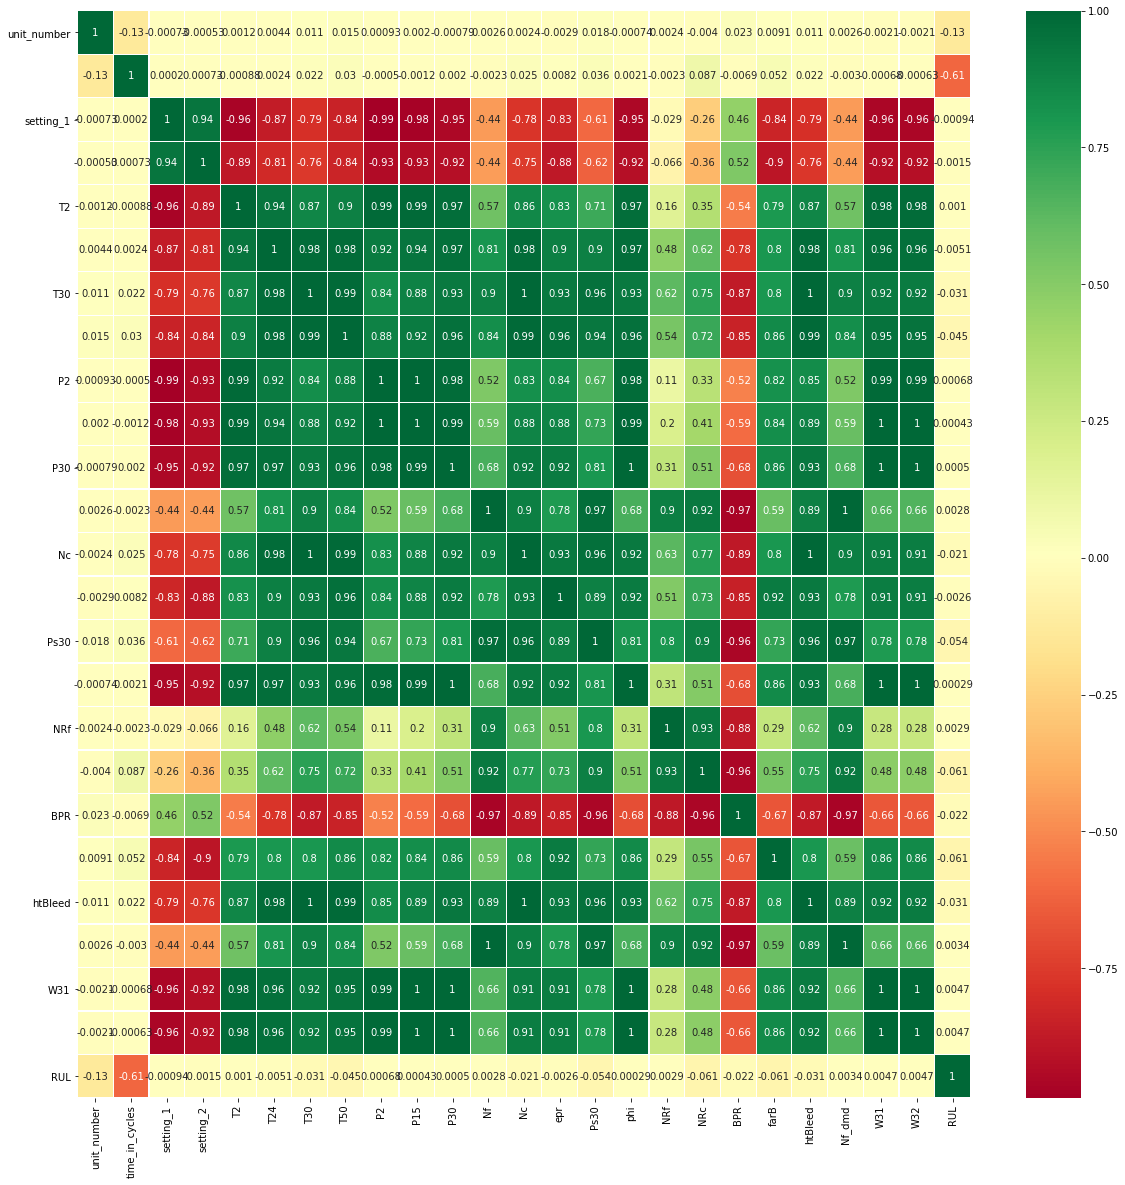

In [241]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [242]:
#Removing unit_number and other features that are weakly correlated with output-RUL
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','P15','P2','P30','phi'])
fd_test = fd_test.drop(columns = ['P15','P2','P30','phi'])
train_df.head()

,time_in_cycles,setting_1,setting_2,T2,T24,T30,T50,Nf,Nc,epr,Ps30,NRf,NRc,BPR,farB,htBleed,Nf_dmd,W31,W32,RUL
0,1,42.0049,0.8400,445.00,549.68,1343.43,1112.93,2211.86,8311.32,1.01,41.69,2387.99,8074.83,9.3335,0.02,330,2212,10.62,6.3670,320
1,2,20.0020,0.7002,491.19,606.07,1477.61,1237.50,2323.66,8713.60,1.07,43.94,2387.73,8046.13,9.1913,0.02,361,2324,24.37,14.6552,319
2,3,42.0038,0.8409,445.00,548.95,1343.12,1117.05,2211.92,8306.69,1.01,41.66,2387.97,8066.62,9.4007,0.02,329,2212,10.48,6.4213,318
3,4,42.0000,0.8400,445.00,548.70,1341.24,1118.03,2211.88,8312.35,1.02,41.68,2388.02,8076.05,9.3369,0.02,328,2212,10.54,6.4176,317
4,5,25.0063,0.6207,462.54,536.10,1255.23,1033.59,1915.22,7994.94,0.93,36.48,2028.08,7865.80,10.8366,0.02,305,1915,14.03,8.6754,316


In [243]:
fd_test.head()

,unit_number,time_in_cycles,setting_1,setting_2,T2,T24,T30,T50,Nf,Nc,epr,Ps30,NRf,NRc,BPR,farB,htBleed,Nf_dmd,W31,W32
0,1,1,20.0072,0.7000,491.19,606.67,1481.04,1227.81,2323.67,8704.98,1.07,43.83,2387.78,8048.98,9.2229,0.02,362,2324,24.31,14.7007
1,1,2,24.9984,0.6200,462.54,536.22,1256.17,1031.48,1915.21,7999.94,0.93,36.11,2028.09,7863.46,10.8632,0.02,306,1915,14.36,8.5748
2,1,3,42.0000,0.8420,445.00,549.23,1340.13,1105.88,2211.93,8305.38,1.01,41.52,2387.95,8071.13,9.3960,0.02,328,2212,10.39,6.4365
3,1,4,42.0035,0.8402,445.00,549.19,1339.70,1107.26,2211.89,8301.00,1.01,41.73,2387.90,8078.89,9.3594,0.02,328,2212,10.56,6.2367
4,1,5,35.0079,0.8400,449.44,555.10,1353.04,1117.80,2222.71,8331.05,1.02,41.32,2387.87,8057.83,9.3030,0.02,333,2223,14.85,8.9326


In [244]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [245]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]

In [246]:
train_df.columns[0:-1]

Index(['time_in_cycles', 'setting_1', 'setting_2', 'T2', 'T24', 'T30', 'T50',
       'Nf', 'Nc', 'epr', 'Ps30', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed',
       'Nf_dmd', 'W31', 'W32'],
      dtype='object')

In [247]:
def lstm_data_preprocessing(raw_train_data, raw_test_data, raw_RUL_data):
    train_df = raw_train_data
    test_df = raw_test_data
    truth_df = raw_RUL_data
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    
    #################
    # TRAIN
    #################
    
    # MinMax normalization (from 0 to 1)
    cols_normalize = train_df.columns.difference(['unit_number','time_in_cycles','RUL']) # NORMALIZE COLUMNS except [id , cycle, rul ....]
    print(cols_normalize)
    min_max_scaler = MinMaxScaler()

    train_df[cols_normalize] = min_max_scaler.fit_transform(train_df[cols_normalize])
    pickle.dump(min_max_scaler, open('min_max_scaler.pkl', 'wb'))

    print("train_df >> ",train_df.head())
    print("\n")

    
    #################
    # TEST
    #################
    
    # MinMax normalization (from 0 to 1)
    test_df[cols_normalize] = min_max_scaler.transform(test_df[cols_normalize])
    
    
    # generate RUL for test data
    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']
    truth_df.columns = ['more']
    truth_df['unit_number'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more'] # adding true-rul vlaue + max cycle of test data set
    truth_df.drop('more', axis=1, inplace=True)

    
    test_df = test_df.merge(truth_df, on=['unit_number'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
    test_df.drop('max', axis=1, inplace=True) 

    
    # pick a large window size of 50 cycles
    sequence_length = 100

    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # for one id I put all the rows in a single matrix
        data_matrix = id_df[seq_cols].values
        num_elements = data_matrix.shape[0]
        # Iterate over two lists in parallel.
        # For example id1 have 192 rows and sequence_length is equal to 50
        # so zip iterate over two following list of numbers (0,112),(50,192)
        # 0 50 -> from row 0 to row 50
        # 1 51 -> from row 1 to row 51
        # 2 52 -> from row 2 to row 52
        # ...
        # 111 191 -> from row 111 to 191
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_matrix[start:stop, :]

    # pick the feature columns 
    sequence_cols = list(train_df.columns[1:-1])

    print(sequence_cols)

    # generator for the sequences
    # transform each id of the train dataset in a sequence
    seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols)) 
               for id in train_df['unit_number'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(seq_array.shape)

    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # For one id I put all the labels in a single matrix.
        # For example:
        # [[1]
        # [4]
        # [1]
        # [5]
        # [9]
        # ...
        # [200]] 
        data_matrix = id_df[label].values
        num_elements = data_matrix.shape[0]
        # I have to remove the first seq_length labels
        # because for one id the first sequence of seq_length size have as target
        # the last label (the previus ones are discarded).
        # All the next id's sequences will have associated step by step one label as target.
        return data_matrix[seq_length:num_elements, :]

    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['RUL']) 
                 for id in train_df['unit_number'].unique()]

    label_array = np.concatenate(label_gen).astype(np.float32)
    print(label_array.shape)
    print(label_array)
    
    return seq_array, label_array, test_df, sequence_length, sequence_cols

In [248]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 128 units followed by another LSTM layer with 64 units. 
    # Dropout is also applied after each LSTM layer to control overfitting.
    # Then an additional Dense layer is applied with 32 neurons for better learning
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=256,
             return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(
              units=128,
              return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=nb_out, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae',r2_keras])

    print(model.summary())
    curr_dt_time = datetime.datetime.now()
    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff 
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{r2_keras:.5f}-{val_r2_keras:.5f}.h5'
    callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'),
                 keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1, verbose=1)]
    history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.1, verbose=2, callbacks=callbacks)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [249]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

In [250]:
def lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols):
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [lstm_test_df[lstm_test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                           for id in lstm_test_df['unit_number'].unique() if len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    # Similarly, we pick the labels
    y_mask = [len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length for id in lstm_test_df['unit_number'].unique()]
    label_array_test_last = lstm_test_df.groupby('unit_number')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

    estimator = model

    # test metrics
    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    score_eval = score_func(y_true_test, y_pred_test)
    test_set = pd.DataFrame(y_pred_test)
    #print(test_set.head())

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test)
    plt.plot(y_true_test, color="orange")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    # fig_verify.savefig("model_regression_verify.png")
    return score_eval[0], score_eval[1], score_eval[2]

In [251]:
RUL4 = pd.read_csv("CMAPSSData/RUL_FD004.txt", sep=" ", header=None)
RUL2 = pd.read_csv("CMAPSSData/RUL_FD002.txt", sep=" ", header=None)
RUL = RUL4.append(RUL2).reset_index(drop=True)
RUL.describe()

,0,1
count,507.000000,0.0
mean,83.810651,NaN
std,54.264464,NaN
min,6.000000,NaN
25%,35.500000,NaN
50%,83.000000,NaN
75%,123.500000,NaN
max,195.000000,NaN


In [252]:
RUL.head()

,0,1
0,22,NaN
1,39,NaN
2,107,NaN
3,75,NaN
4,149,NaN


In [253]:
RUL.to_csv('fd_RUL.csv', index=False)

In [254]:
train_df_lstm = pd.concat([unit_number, train_df], axis=1)
y_true = RUL[0].to_numpy()
seq_array, label_array, test_df, sequence_length, sequence_cols = lstm_data_preprocessing(train_df_lstm, fd_test.copy(), RUL.copy())

Index(['BPR', 'NRc', 'NRf', 'Nc', 'Nf', 'Nf_dmd', 'Ps30', 'T2', 'T24', 'T30',
       'T50', 'W31', 'W32', 'epr', 'farB', 'htBleed', 'setting_1',
       'setting_2'],
      dtype='object')
train_df >>     unit_number  time_in_cycles  setting_1  setting_2        T2       T24  \
0            1               1   0.999926   0.997625  0.000000  0.130227   
1            1               2   0.476147   0.831591  0.626985  0.647377   
2            1               3   0.999900   0.998694  0.000000  0.123533   
3            1               4   0.999810   0.997625  0.000000  0.121240   
4            1               5   0.595275   0.737173  0.238089  0.005686   

        T30       T50        Nf        Nc  ...      Ps30       NRf       NRc  \
0  0.272082  0.213813  0.626983  0.265451  ...  0.453087  0.993111  0.541848   
1  0.634407  0.512542  0.862888  0.592202  ...  0.633520  0.992395  0.473954   
2  0.271245  0.223693  0.627110  0.261690  ...  0.450682  0.993056  0.522426   
3  0.266168  0.226043 

In [255]:
np.save('seq_array.npy', seq_array)
np.save('label_array.npy', label_array)

In [256]:
import time
start = time.time()
model_instance, history = lstm_train(seq_array, label_array, sequence_length)
end = time.time()
duration = (end - start) / 60
print(duration)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 256)          282624    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [ ]:
(seq_array.size * seq_array.itemsize) / (1024*1024)

In [263]:
from tensorflow.keras.models import load_model
dependencies = {
    'r2_keras': r2_keras
}
model_lstm = load_model('model_init_2021-07-2113_58_48.008908/model-00098-897.65367-0.77949-0.70747.h5', custom_objects=dependencies)

 compatitive score 5571.1
 mean absolute error 13.170000076293945
 root mean squared error 18.784035677614398
 R2 score 0.84


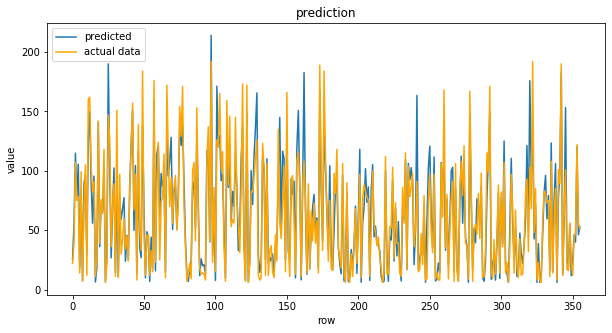

In [264]:
# Test Evaluation
model_metrics = lstm_valid_evaluation(test_df, model_lstm, sequence_length, sequence_cols)

In [265]:
train_df.head()

,time_in_cycles,setting_1,setting_2,T2,T24,T30,T50,Nf,Nc,epr,Ps30,NRf,NRc,BPR,farB,htBleed,Nf_dmd,W31,W32,RUL
0,1,42.0049,0.8400,445.00,549.68,1343.43,1112.93,2211.86,8311.32,1.01,41.69,2387.99,8074.83,9.3335,0.02,330,2212,10.62,6.3670,320
1,2,20.0020,0.7002,491.19,606.07,1477.61,1237.50,2323.66,8713.60,1.07,43.94,2387.73,8046.13,9.1913,0.02,361,2324,24.37,14.6552,319
2,3,42.0038,0.8409,445.00,548.95,1343.12,1117.05,2211.92,8306.69,1.01,41.66,2387.97,8066.62,9.4007,0.02,329,2212,10.48,6.4213,318
3,4,42.0000,0.8400,445.00,548.70,1341.24,1118.03,2211.88,8312.35,1.02,41.68,2388.02,8076.05,9.3369,0.02,328,2212,10.54,6.4176,317
4,5,25.0063,0.6207,462.54,536.10,1255.23,1033.59,1915.22,7994.94,0.93,36.48,2028.08,7865.80,10.8366,0.02,305,1915,14.03,8.6754,316


In [266]:
X = train_df.iloc[:,:19].to_numpy() 
Y = train_df.iloc[:,19:].to_numpy()
Y = np.ravel(Y)

In [267]:
print(len(X))
print(len(Y))
print(len(train_df))

115008
115008
115008


In [268]:
model_rf = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
model_rf.fit(X,Y)

RandomForestRegressor(max_depth=5, max_features=7, n_estimators=70, n_jobs=-1,
                      random_state=1)

In [269]:
model_xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=5,silent=True)
model_xgb.fit(X,Y)

XGBRegressor(colsample_bytree=0.5, learning_rate=0.018, max_depth=5,
             n_estimators=110, silent=True, subsample=0.8)

In [270]:
test_max = fd_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']
fd_test = fd_test.merge(test_max, on=['unit_number'], how='left')
test = fd_test[fd_test['time_in_cycles'] == fd_test['max']].reset_index()
test.drop(columns=['unit_number','index','max'],inplace = True)
test.head()

,time_in_cycles,setting_1,setting_2,T2,T24,T30,T50,Nf,Nc,epr,Ps30,NRf,NRc,BPR,farB,htBleed,Nf_dmd,W31,W32
0,230,25.0070,0.6214,462.54,537.66,1264.31,1046.41,1915.66,8023.10,0.94,36.87,2028.53,7890.31,10.7615,0.02,308,1915,14.41,8.6329
1,153,41.9989,0.8400,445.00,549.96,1354.05,1133.55,2211.69,8310.36,1.02,42.29,2387.72,8073.44,9.3925,0.02,331,2212,10.58,6.4325
2,141,42.0005,0.8401,445.00,549.47,1341.06,1118.90,2212.04,8331.13,1.02,41.82,2388.18,8095.58,9.2974,0.02,330,2212,10.61,6.3488
3,208,25.0018,0.6207,462.54,536.06,1253.49,1038.53,1915.39,8012.46,0.94,36.57,2028.30,7878.63,10.8396,0.02,306,1915,14.41,8.5696
4,51,25.0039,0.6200,462.54,537.36,1263.60,1052.52,1915.36,8011.76,0.94,37.11,2028.24,7873.75,10.9094,0.02,307,1915,14.19,8.6248


In [271]:
X_test = test.to_numpy()

In [272]:
X_test.shape

(507, 19)

In [273]:
y_pred_rf = model_rf.predict(X_test)

In [274]:
RF_individual_scorelst = score_func(y_true, y_pred_rf)

 compatitive score 47912.48
 mean absolute error 30.09
 root mean squared error 36.523143347745965
 R2 score 0.55


In [275]:
y_pred_xgb = model_xgb.predict(X_test)

In [276]:
XGB_individual_scorelst = score_func(y_true, y_pred_xgb)

 compatitive score 58643.18
 mean absolute error 22.71
 root mean squared error 29.02602280712947
 R2 score 0.71


In [277]:
import pickle
with open('model_rf.pickle', 'wb') as f:
    pickle.dump(model_rf,f)
with open('model_xgb.pickle', 'wb') as f:
    pickle.dump(model_xgb,f)

In [ ]:
rf_f = open('model_rf.pickle','rb')
loaded_model_rf = pickle.load(rf_f)

xgb_f = open('model_xgb.pickle','rb')
loaded_model_xgb = pickle.load(xgb_f)

In [ ]:
y_pred_rf = loaded_model_rf.predict(X_test)
y_pred_xgb = loaded_model_xgb.predict(X_test)

In [ ]:
score_func(y_true, y_pred_rf)

In [ ]:
score_func(y_true, y_pred_xgb)

In [ ]:
fd_test_save = [fd_test[fd_test['unit_number']==id][sequence_cols].values[-sequence_length:] 
                           for id in fd_test['unit_number'].unique() if len(fd_test[fd_test['unit_number']==id]) >= sequence_length]


In [ ]:
eng0 = pd.DataFrame(fd_test_save[0])
eng1 = pd.DataFrame(fd_test_save[1])
eng2 = pd.DataFrame(fd_test_save[2])
eng3 = pd.DataFrame(fd_test_save[3])
eng4 = pd.DataFrame(fd_test_save[4])

In [ ]:
eng0.to_csv('engine0.csv', index=False)
eng1.to_csv('engine1.csv', index=False)
eng2.to_csv('engine2.csv', index=False)
eng3.to_csv('engine3.csv', index=False)
eng4.to_csv('engine4.csv', index=False)

In [ ]:
f = open('min_max_scaler.pkl','rb')
min_max = pickle.load(f)

In [ ]:
data = pd.read_csv('engine1.csv')
data.columns = sequence_cols

In [ ]:
print(sequence_cols)

In [ ]:
data.head()

In [ ]:
cols_normalize = ['BPR', 'NRc', 'NRf', 'Nc', 'Nf', 'Nf_dmd', 'Ps30', 'T2', 'T24', 'T30',
       'T50', 'W31', 'W32', 'epr', 'farB', 'htBleed', 'setting_1',
       'setting_2']

In [ ]:
data[cols_normalize] = min_max.transform(data[cols_normalize])

In [ ]:
data.head()

In [ ]:
data = np.asarray(data).astype(np.float32)
data = np.expand_dims(data, axis=0)
RUL = model_lstm.predict(data)

In [ ]:
RUL

In [ ]:
int(RUL[0][0])